In [1]:
import sys  
sys.path.insert(0, '/home/yiyi/nlp_tm/models/DETM')

In [2]:
import torch
import os
import pickle
import csv
import numpy as np
import torch

In [1]:
from __future__ import print_function

import argparse
import torch
import pickle 
import numpy as np 
import os 
import math 
import random 
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.io

import data 

from sklearn.decomposition import PCA
from torch import nn, optim
from torch.nn import functional as F

from detm import DETM
from utils import nearest_neighbors, get_topic_coherence

import pandas as pd

device: cuda:3
device: cuda:3


In [2]:
filepath = 'results/detm_twitter_K_75_Htheta_800_Optim_adam_Clip_0.0_ThetaAct_relu_Lr_0.005_Bsz_1000_RhoSize_300_L_3_minDF_10_trainEmbeddings_1_val_ppl_2741.7_epoch_14'

In [3]:
model_path = os.path.join('/home/yiyi/nlp_tm/', filepath)

In [4]:
with open(model_path, 'rb') as f:
    model = torch.load(f)

In [5]:
model

DETM(
  (t_drop): Dropout(p=0.0, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=20865, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=20940, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=800, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=800, out_features=75, bias=True)
  (logsigma_q_theta): Linear(in_features=800, out_features=75, bias=True)
  (q_eta_map): Linear(in_features=20865, out_features=200, bias=True)
  (q_eta): LSTM(200, 200, num_layers=3)
  (mu_q_eta): Linear(in_features=275, out_features=75, bias=True)
  (logsigma_q_eta): Linear(in_features=275, out_features=75, bias=True)
)

In [12]:
from utils import nearest_neighbors
import csv

In [7]:
with open(os.path.join('/home/yiyi/nlp_tm/preprocessed_data', 'vocab.pkl'), 'rb') as f:
        vocab = pickle.load(f)

In [8]:
len(vocab)

20865

In [9]:
model.eval()
with torch.no_grad():
    alpha= model.mu_q_alpha
    beta = model.get_beta(alpha)
    print(alpha.shape)
    print(beta.shape)

torch.Size([75, 8, 300])
torch.Size([75, 8, 20865])


In [19]:
def visualize(num_topics, num_words, vocab):
    """Visualizes topics and embeddings and word usage evolution.
    """
    csvfile = open(f'topic_visualization_topnum{num_topics}.csv', 'w', newline='')
    csvwriter = csv.writer(csvfile, delimiter= ',', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['Topic', 'Time', 'Topic Words'])
    model.eval()
    with torch.no_grad():
        alpha = model.mu_q_alpha
        beta = model.get_beta(alpha) 
        print('beta: ', beta.size())
        print('\n')
        print('#'*100)
        print('Visualize topics...')
        times = [x for x in range(8)]
        topics_words = []
        for k in range(num_topics):
            for t in times:
                gamma = beta[k, t, :]
                top_words = list(gamma.cpu().numpy().argsort()[-num_words+1:][::-1])
                topic_words = [vocab[a] for a in top_words]
                topics_words.append(' '.join(topic_words))
                
                csvwriter.writerow([k, t+2013, topic_words])
                
                print('Topic {} .. Time: {} ===> {}'.format(k, t, topic_words)) 

        print('\n')
        print('Visualize word embeddings ...')
        queries = ['immigrant', 'refugee', 'immigration']
        try:
            embeddings = model.rho.weight  # Vocab_size x E
        except:
            embeddings = model.rho         # Vocab_size x E
        neighbors = []
        for word in queries:
            print('word: {} .. neighbors: {}'.format(
                word, nearest_neighbors(word, embeddings, vocab, num_words)))
        print('#'*100)
        return embeddings

In [20]:
embeddings = visualize(75, 20, vocab)

beta:  torch.Size([75, 8, 20865])


####################################################################################################
Visualize topics...
Topic 0 .. Time: 0 ===> ['swisslife', 'excellent', 'mum', 'episode', 'pitch', 'putin', 'dad', 'region', 'grant', 'overnight', 'tour', 'piss', 'arabs', 'list', 'sweet', 'obama', 'abt', 'light', 'emergency']
Topic 0 .. Time: 1 ===> ['europedebate', 'clegg', 'mahool', 'pmoi', 'cheek', 'gaza', 'karma', 'ahaha', 'obama', 'rt', 'swe', 'nick', 'poulter', 'interraile', 'cameron', 'thebigbritishimmigrationrow', 'freak', 'withsyria', 'haha']
Topic 0 .. Time: 2 ===> ['euskadibasquecountry', 'iraq', 'chaotic', 'exploreparis', 'immigrationstreet', 'aliens', 'village', 'province', 'regime', 'announce', 'contract', 'abandon', 'germany', 'holland', 'jews', 'bomb', 'collect', 'keith', 'ed']
Topic 0 .. Time: 3 ===> ['europe', 'trip', 'basque', 'catalonia', 'cologne', 'bilbao', 'spain', 'dinghy', 'provence', 'middlesbrough', 'travelingram', 'exil', '

In [15]:
embeddings.shape

(20865, 300)

In [19]:
keywords_ =['immigrant', 'refugee', 'immigration', 'asylum', 'exile', 'migrant']

In [20]:
from sklearn import cluster
from sklearn import metrics

In [21]:
# vectors of whole embeddings.
indexes_keywords = [vocab.index(word) for word in keywords_]
queries = [embeddings[index] for index in indexes_keywords] # vectors of the keywords

In [22]:
kmeans = cluster.KMeans(n_clusters=1, random_state=0).fit(queries)

In [23]:
centroid = kmeans.cluster_centers_[0]

In [24]:
ranks= embeddings.dot(centroid).squeeze()
denom = centroid.T.dot(centroid).squeeze()
denom = denom*np.sum(embeddings*2, 1)
ranks = ranks/denom


In [25]:
mostSimilar = []
[mostSimilar.append(idx) for idx in ranks.argsort()[::-1]]
nearest_neighbors = mostSimilar[:50]
nearest_neighbors = [vocab[comp] for comp in nearest_neighbors]

In [26]:
nearest_neighbors

['bark',
 'judgemental',
 'pep',
 'scorch',
 'bozo',
 'foreignpolicy',
 'jingoistic',
 'psychiatrist',
 'winston',
 'dunlin',
 'israels',
 'kickoff',
 'criminaljustice',
 'skewed',
 'vocation',
 'authorize',
 'impressive',
 'jardin',
 'smokescreen',
 'labourantisemitism',
 'gandhi',
 'fwiw',
 'statelessnesscancelled',
 'scottishindependence',
 'mono',
 'tt',
 'debilitate',
 'wavy',
 'fag',
 'westgate',
 'stephanie',
 'deutsche',
 'baloch',
 'additionally',
 'placard',
 'srhr',
 'nomad',
 'amass',
 'facemask',
 'dolonne',
 'pl',
 'roughly',
 'organic',
 'admiration',
 'foresee',
 'tandem',
 'rewind',
 'regulator',
 'thesis',
 'indyscotland']

In [37]:
from sklearn.manifold import TSNE

In [29]:
keywords_.append('centroid')

In [35]:
keywords_

['immigrant',
 'refugee',
 'immigration',
 'asylum',
 'exile',
 'migrant',
 'centroid']

In [30]:
queries.append(centroid)

In [31]:
len(queries)

8

In [32]:
query_arr = np.array(queries)

In [33]:
query_arr.shape

(8, 300)

In [34]:
len(keywords_)

7

In [40]:
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=7)
T = tsne.fit_transform(query_arr[:-1])

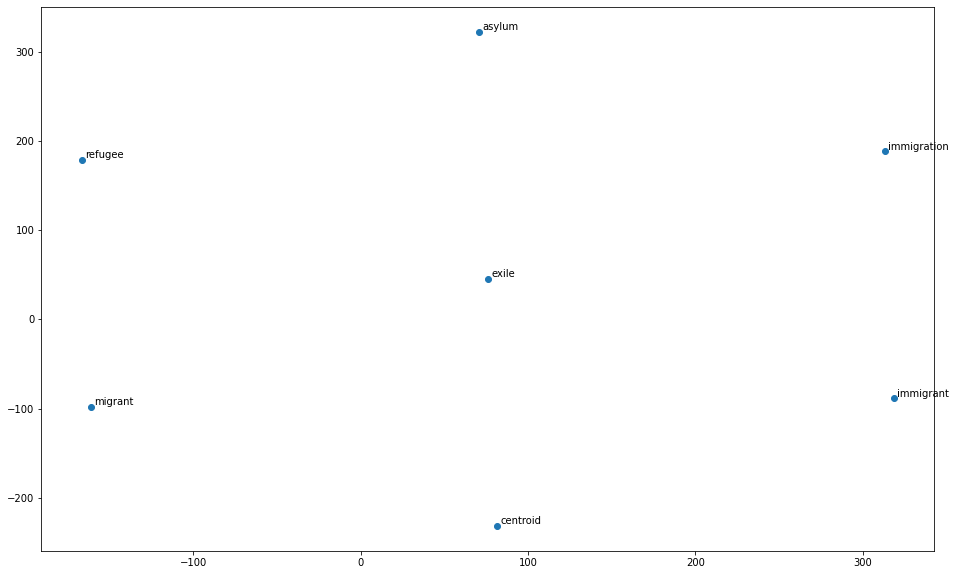

In [41]:
plt.figure(figsize=(16,10))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(keywords_, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+2, y+2), xytext=(0, 0), textcoords='offset points')